# Model Training

We will train various models:
1. Raw DeBERTa-v3-base fine-tuning and large randomised hyperparameter search.
2. DeBERTa-v3-base fine-tuning with POS and NER features and constrained hyperparameter grid search.
3. DeBERTa-v3-base fine-tuning with z-scores from log-odds with Dirchlet prior features, ditto grid search.
4. DeBERTa-v3-base fine-tuning with both of the above, ditto grid search.

**This file is for "1."**

In [2]:
import os
import re
import random
import logging
import math
import json
import gc
from enum import Enum
from html import unescape

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import optuna
from optuna.visualization.matplotlib import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate
)
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import spacy

from utils.data import clean_text, load_data
from utils.split import split_train_val
from utils.feature import extract_pos_features, extract_ner_features, extract_pos_ner_features
from utils.fightin_words import compute_fightin_words_zscores, extract_zscore_features
from utils.pcl_deberta import PoolingStrategy
from utils.pcl_dataset import PCLDataset

SEED = 42
DATA_DIR = "data"
OUT_DIR = "out"
MODEL_NAME = "microsoft/deberta-v3-base"
MAX_LENGTH = 256
VAL_FRACTION = 0.15
N_TRIALS = 60
NUM_EPOCHS = 12
PATIENCE = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True

logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s:\t%(message)s")
LOG = logging.getLogger(__name__)
LOG.info(f"Device: {DEVICE}")

2026-02-21 10:50:29,655 INFO:	Device: cuda


## 1. Data Loading and Preprocessing
Load the main PCL dataset, join with the official SemEval train/dev splits, binarise labels, and clean HTML artifacts.

In [ ]:
# Use utils for data loading and cleaning
train_df, dev_df = load_data(DATA_DIR)
train_df.head()

2026-02-16 09:14:13,849 INFO:	Train: 8375 samples, 794 positive (9.48%)
2026-02-16 09:14:13,850 INFO:	Dev:   2093 samples, 199 positive (9.51%)


,text,binary_label
par_id,,
1,"We 're living in times of absolute insanity , ...",0
2,"In Libya today , there are countless number of...",0
3,White House press secretary Sean Spicer said t...,0
4,Council customers only signs would be displaye...,0
5,""" Just like we received migrants fleeing El Sa...",0


In [ ]:
matches = 0
for df in [train_df, dev_df]:
    for row in df.itertuples():
        para = str(row.text)
        for match in re.finditer(r"<[^>]+>|<\/[^>]+>|&\w+;|\n|\\n|\s{2,}|\r|\\r|@@\d+|[^\x00-\x7F]+|https?://\S+", para):
            LOG.warning(f"Found noise in par_id {row.Index}: '{match.group(0)}'")
            matches += 1
LOG.info(f"Total noise matches found: {matches}")

2026-02-16 09:14:14,023 INFO:	Total noise matches found: 0


In [4]:
def split_train_val(train_df: pd.DataFrame, val_frac: float = VAL_FRACTION, seed: int = SEED):
    """
    Stratified split of training data into train_sub and val_sub.
    Returns (train_sub_df, val_sub_df).
    """
    train_sub, val_sub = train_test_split(
        train_df, test_size=val_frac, random_state=seed,
        stratify=train_df["binary_label"]
    )
    LOG.info(f"Train-sub: {len(train_sub)} ({train_sub['binary_label'].sum()} pos, {train_sub['binary_label'].mean()*100:.2f}%), "
             f"Val-sub: {len(val_sub)} ({val_sub['binary_label'].sum()} pos, {val_sub['binary_label'].mean()*100:.2f}%)")
    return train_sub, val_sub

train_sub_df, val_sub_df = split_train_val(train_df)
val_sub_df.head()

2026-02-16 09:14:14,598 INFO:	Train-sub: 7118 (675 pos, 9.48%), Val-sub: 1257 (119 pos, 9.47%)


,text,binary_label
par_id,,
124,"The ruling by the judge , released Thursday , ...",0
1515,News Rescuing the mentally ill CUMI provides h...,1
6356,"According to documents , the project will enab...",0
1008,"As a fashion icon , Rissa knows the importance...",0
6173,The new rules are not so much an outright ban ...,0


## 2. PyTorch Dataset and DataLoader
Custom Dataset class that pre-tokenizes all texts with the DeBERTa tokeniser at construction time.

In [3]:
tokeniser = AutoTokenizer.from_pretrained(MODEL_NAME)
LOG.info(f"Tokeniser loaded: {tokeniser.__class__.__name__}")
from utils.dataloaders import make_dataloaders

2026-02-21 10:50:34,388 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-21 10:50:34,397 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-21 10:50:34,658 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/tokenizer_config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-21 10:50:34,667 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/tokenizer_config.json "HTTP/1.1 200 OK"
2026-02-21 10:50:34,766 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/tree/main/additional_chat_templates?recursive=false&expand=false "HTTP/1.1 404 Not Found"
2026-02-21 10:50:34,868 INFO:	HTTP Request: GET https://huggingface.co/api/model

## 3. Model Architecture
DeBERTa backbone + custom classifier head. The head is designed for future concatenation of extra features (POS/NER proportions, z-score features) but for Experiment 1 uses only the pooled embedding.

**Pooling strategy** (searched as a hyperparameter): DeBERTa-v3 was pretrained with Replaced Token Detection (RTD), not Next Sentence Prediction (NSP), so unlike BERT the [CLS] token has no specially-trained summary representation. We search over four strategies:
- **CLS**: First token representation — simple baseline, default for most HuggingFace classifiers.
- **Mean**: Attention-mask-weighted average across all tokens — captures distributional information.
- **Max**: Element-wise max across non-padding tokens — captures the strongest activation per feature dimension, complementary to mean.
- **CLS+Mean**: Concatenation of CLS and mean-pooled representations (input dim 1536) — lets the head leverage both the global CLS signal and the distributional mean signal.

**Classifier head design**: We use a two-layer MLP (Linear -> GELU -> Dropout -> Linear) rather than a single linear layer. A single linear layer can only learn a linear relationship but we want to be able to learn non-linear relationships (between transformer embeddings, POS/NER proportions, and z-scores). The hidden layer with GELU activation allows the head to learn nonlinear combinations of these features. GELU is chosen over ReLU because it is continuously differentiable and never has zero gradient, avoiding the dying neuron problem where ReLU. A deeper classification head might overfit given the small-ish dataset (~8k training samples).

In [ ]:
from utils.pcl_deberta import PCLClassifierHead

In [ ]:
from utils.pcl_deberta import PCLDeBERTa

## 4. Loss Function, Scheduler, and Training Infrastructure
Weighted BCE loss for class imbalance, cosine annealing with warmup, early stopping, and evaluation utilities.

In [ ]:
from utils.optim import get_cosine_schedule_with_warmup, compute_pos_weight

In [ ]:
from utils.early_stopping import EarlyStopping

In [ ]:
from utils.eval import evaluate, find_best_threshold

## 5. Training Loop
Single training function used both for manual runs and as the Optuna objective. Uses differential learning rates (backbone vs head), gradient clipping, step-based evaluation, and Optuna pruning.

In [ ]:
"""def train_model(
    model: PCLDeBERTa,
    train_loader: DataLoader,
    val_loader: DataLoader,
    dev_loader: DataLoader,
    pos_weight: torch.Tensor,
    lr: float,
    weight_decay: float,
    num_epochs: int,
    warmup_fraction: float,
    patience: int,
    head_lr_multiplier: float = 3.0,
    label_smoothing: float = 0.0,
    eval_every_n_steps: int = 50,
    trial: optuna.trial.Trial | None = None
) -> dict:
    
    Train the model with early stopping, cosine annealing with warmup,
    and weighted BCE loss.

    Args:
        head_lr_multiplier: The head LR is lr * head_lr_multiplier.
        label_smoothing: Smooths binary targets towards 0.5.
            y_smooth = y * (1 - label_smoothing) + 0.5 * label_smoothing

    Returns dict with keys: best_val_f1, best_threshold, dev_metrics, train_losses.
    
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    # Differential LR: head learns head_lr_multiplier times faster than backbone
    backbone_params = list(model.backbone.parameters())
    head_params = list(model.classifier.parameters())
    optimizer = AdamW([
        {"params": backbone_params, "lr": lr},
        {"params": head_params, "lr": lr * head_lr_multiplier}
    ], weight_decay=weight_decay)

    total_steps = len(train_loader) * num_epochs
    warmup_steps = int(total_steps * warmup_fraction)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps)

    # Scale patience from epochs to eval rounds so early stopping works in epoch units
    evals_per_epoch = max(1, len(train_loader) // eval_every_n_steps)
    patience_in_evals = patience * evals_per_epoch
    early_stopper = EarlyStopping(patience=patience_in_evals)
    LOG.info(f"Early stopping: patience={patience} epochs = {patience_in_evals} eval rounds "
             f"({evals_per_epoch} evals/epoch, eval every {eval_every_n_steps} steps)")

    model.train()
    global_step = 0
    train_losses = []
    best_val_f1 = 0.0
    best_state_dict = None
    running_loss = 0.0

    for epoch in range(num_epochs):
        LOG.info(f"Epoch {epoch+1}/{num_epochs}")
        for batch in train_loader:
            input_ids = batch["input_ids"].to(DEVICE)
            attention_mask = batch["attention_mask"].to(DEVICE)
            labels = batch["labels"].to(DEVICE)

            # Label smoothing: push targets towards 0.5
            if label_smoothing > 0:
                labels = labels * (1 - label_smoothing) + 0.5 * label_smoothing

            optimizer.zero_grad()
            unnormalised_scores = model(input_ids=input_ids, attention_mask=attention_mask).squeeze(-1)
            loss = criterion(unnormalised_scores, labels)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()
            scheduler.step()

            running_loss += loss.item()
            global_step += 1

            if global_step % eval_every_n_steps == 0:
                avg_train_loss = running_loss / eval_every_n_steps
                train_losses.append(avg_train_loss)
                running_loss = 0.0

                val_metrics = evaluate(model, val_loader)
                val_f1 = val_metrics["f1"]

                LOG.info(
                    f"Step {global_step} | Train Loss: {avg_train_loss:.4f} | "
                    f"Val F1: {val_f1:.4f} | Val P: {val_metrics['precision']:.4f} | "
                    f"Val R: {val_metrics['recall']:.4f}"
                )

                if val_f1 > best_val_f1:
                    best_val_f1 = val_f1
                    # Store on CPU to save GPU memory
                    best_state_dict = {k: v.cpu().clone() for k, v in model.state_dict().items()}

                # Optuna pruning
                if trial is not None:
                    trial.report(val_f1, global_step)
                    if trial.should_prune():
                        raise optuna.exceptions.TrialPruned()

                if early_stopper.step(val_f1):
                    LOG.info(f"Early stopping at step {global_step}")
                    break

        if early_stopper.should_stop:
            break

    # Restore best model and evaluate on dev set
    if best_state_dict is not None:
        model.load_state_dict(best_state_dict)

    # Find optimal threshold on val set, apply to dev evaluation
    best_thresh, thresh_val_f1 = find_best_threshold(model, val_loader)
    LOG.info(f"Optimal threshold: {best_thresh:.3f} (val F1 with threshold: {thresh_val_f1:.4f}, "
             f"val F1 @0.5: {best_val_f1:.4f})")

    dev_metrics = evaluate(model, dev_loader, threshold=best_thresh)
    LOG.info(
        f"Dev F1: {dev_metrics['f1']:.4f} | "
        f"Dev P: {dev_metrics['precision']:.4f} | Dev R: {dev_metrics['recall']:.4f} | "
        f"Threshold: {best_thresh:.3f}"
    )

    return {
        "best_val_f1": thresh_val_f1,  # Use threshold-optimised val F1
        "best_threshold": best_thresh,
        "dev_metrics": dev_metrics,
        "train_losses": train_losses
    }"""
from utils.training_loop import train_model

## 6. Hyperparameter Search with Optuna
Randomised search over learning rate, batch size, hidden dim, dropout, weight decay, warmup fraction, and number of epochs. The objective is dev-set F1.

In [ ]:
def objective(trial: optuna.trial.Trial) -> float:
    """
    Optuna objective for Experiment 1.
    Returns threshold-optimised val-set F1 score (to be maximised).
    Dev-set metrics are stored as user attributes for inspection only.
    """
    lr = trial.suggest_float("lr", 1e-6, 8e-5, log=True)
    batch_size = 32  # batch_size=16 consistently failed in initial search
    # hidden_dim=0 means single Linear layer (like SimpleTransformers),
    # hidden_dim>0 means 2-layer MLP with that hidden size
    hidden_dim = trial.suggest_categorical("hidden_dim", [0, 128, 256, 512])
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.4, step=0.05) if hidden_dim > 0 else 0.0
    weight_decay = trial.suggest_float("weight_decay", 1e-4, 1e-2, log=True)
    warmup_fraction = trial.suggest_float("warmup_fraction", 0.05, 0.25, step=0.05)
    pooling = PoolingStrategy(trial.suggest_categorical("pooling", [s.value for s in PoolingStrategy]))
    head_lr_multiplier = trial.suggest_categorical("head_lr_multiplier", [1, 3, 5, 10])
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.15, step=0.025)
    num_epochs = NUM_EPOCHS
    patience = PATIENCE

    LOG.info(f"Training with hyper parameters:\n"
             f"\tLR -             \t{lr:.2e}\n"
             f"\tBatch Size -     \t{batch_size}\n"
             f"\tHidden Dim -     \t{hidden_dim} ({'MLP' if hidden_dim > 0 else 'Linear'})\n"
             f"\tDropout Rate -   \t{dropout_rate:.2f}\n"
             f"\tWeight Decay -   \t{weight_decay:.2e}\n"
             f"\tWarmup Fraction -\t{warmup_fraction:.2f}\n"
             f"\tPooling -        \t{pooling.value}\n"
             f"\tHead LR Mult -   \t{head_lr_multiplier}x\n"
             f"\tLabel Smoothing -\t{label_smoothing:.3f}\n"
             f"\tNum Epochs -     \t{num_epochs} (fixed)\n"
             f"\tPatience -       \t{patience} (fixed)")

    train_loader, val_loader, dev_loader = make_dataloaders(
        train_sub_df, val_sub_df, dev_df, batch_size, MAX_LENGTH, tokeniser
    )

    model = PCLDeBERTa(
        hidden_dim=hidden_dim,
        dropout_rate=dropout_rate,
        n_extra_features=0,
        pooling=pooling
    ).to(DEVICE)

    pos_weight = compute_pos_weight(train_sub_df, DEVICE)

    results = train_model(
        model=model,
        device=DEVICE,
        train_loader=train_loader,
        val_loader=val_loader,
        dev_loader=dev_loader,
        pos_weight=pos_weight,
        lr=lr,
        weight_decay=weight_decay,
        num_epochs=num_epochs,
        warmup_fraction=warmup_fraction,
        patience=patience,
        head_lr_multiplier=head_lr_multiplier,
        label_smoothing=label_smoothing,
        eval_every_n_steps=50,
        trial=trial
    )

    # Store metrics on the trial for later inspection
    trial.set_user_attr("best_val_f1", results["best_val_f1"])
    trial.set_user_attr("best_threshold", results["best_threshold"])
    trial.set_user_attr("dev_f1", results["dev_metrics"]["f1"])
    trial.set_user_attr("dev_precision", results["dev_metrics"]["precision"])
    trial.set_user_attr("dev_recall", results["dev_metrics"]["recall"])

    # Save model weights if this is the best trial so far
    try:
        prev_best = trial.study.best_value
    except ValueError:  # no completed trials yet
        prev_best = -float("inf")
    if results["best_val_f1"] > prev_best:
        os.makedirs(OUT_DIR, exist_ok=True)
        torch.save({k: v.cpu() for k, v in model.state_dict().items()},
                   os.path.join(OUT_DIR, "exp1_best_model.pt"))
        LOG.info(f"New best model saved (val F1={results['best_val_f1']:.4f})")

    # Aggressively free GPU memory between trials
    del model, train_loader, val_loader, dev_loader
    gc.collect()
    torch.cuda.empty_cache()

    # Optimise on threshold-tuned val F1 (not dev F1) to avoid data leakage
    return results["best_val_f1"]

In [14]:
try:
    del model
except NameError:
    pass
gc.collect()
torch.cuda.empty_cache()

In [15]:

study = optuna.create_study(
    direction="maximize",
    study_name="pcl_deberta_exp1",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_startup_trials=8, n_warmup_steps=500)
)

study.optimize(objective, n_trials=N_TRIALS)

best_trial = study.best_trial
LOG.info(f"Best trial: {best_trial.number}")
LOG.info(f"Best val F1:  {best_trial.user_attrs['best_val_f1']:.4f}")
LOG.info(f"Best threshold: {best_trial.user_attrs['best_threshold']:.3f}")
LOG.info(f"Best dev F1:  {best_trial.user_attrs['dev_f1']:.4f} | "
         f"P: {best_trial.user_attrs['dev_precision']:.4f} | "
         f"R: {best_trial.user_attrs['dev_recall']:.4f}")
LOG.info(f"Best params: {best_trial.params}")

[I 2026-02-16 09:14:17,330] A new study created in memory with name: pcl_deberta_exp1
2026-02-16 09:14:17,332 INFO:	Training with hyper parameters:
	LR -             	5.16e-06
	Batch Size -     	32
	Hidden Dim -     	0 (Linear)
	Dropout Rate -   	0.00
	Weight Decay -   	2.05e-04
	Warmup Fraction -	0.05
	Pooling -        	cls
	Head LR Mult -   	1x
	Label Smoothing -	0.025
	Num Epochs -     	12 (fixed)
	Patience -       	4 (fixed)
2026-02-16 09:14:20,945 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-16 09:14:20,953 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-16 09:14:21,347 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/model.safetensors "HTTP/1.1 404 Not Found"
2026-02-16 09:14:21,348 WARNING:	Warning: You are sending unau

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 09:14:21,814 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 09:54:57,157 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 10:48:24,210 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 11:14:27,322 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors.index.json "HTTP/1.1 404 Not Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 12:17:33,039 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 13:24:37,457 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 14:13:19,073 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 15:06:51,816 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 16:08:42,118 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 16:22:08,918 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 17:08:01,468 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 17:35:25,685 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 18:17:13,568 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors.index.json "HTTP/1.1 404 Not Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 19:20:15,118 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 20:12:41,202 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 20:41:35,041 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors.index.json "HTTP/1.1 404 Not Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 21:31:53,420 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-16 22:37:17,849 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 22:57:48,110 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors "HTTP/1.1 302 Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEX

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 23:09:13,612 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-16 23:20:41,164 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 00:10:11,138 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 00:51:49,126 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 01:43:34,446 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 02:11:25,518 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 02:51:47,530 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 03:03:12,399 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 03:15:47,600 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 03:57:17,126 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 04:08:41,027 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 04:47:53,402 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-17 04:47:53,525 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predic

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 04:59:19,719 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 05:57:49,106 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-17 05:57:49,227 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predic

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 06:42:40,368 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 06:56:23,553 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 07:10:06,077 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 07:28:18,974 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 08:15:39,899 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 08:27:20,192 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 09:30:11,438 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 10:12:49,789 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 10:25:03,097 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 11:15:06,643 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 12:19:53,985 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 12:31:59,379 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 13:28:53,277 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-17 13:28:53,432 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predic

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 14:09:13,119 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 14:55:23,821 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 15:34:29,313 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 15:46:34,968 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 15:59:53,336 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 16:13:11,691 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ign

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 17:18:02,445 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignore

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 18:05:33,069 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-17 18:05:33,213 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predic

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-17 18:59:16,700 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-17 19:33:08,173 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 19:45:45,420 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors.index.json "HTTP/1.1 404 Not Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 19:58:23,316 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/refs%2Fpr%2F14/model.safetensors.index.json "HTTP/1.1 404 Not Found"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-17 20:53:15,457 INFO:	Backbone model loaded: 

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

2026-02-17 21:04:46,911 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/refs%2Fpr%2F14 "HTTP/1.1 200 OK"
DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can

## 7. Results Analysis
Visualise Optuna results and retrain the best model on the full training set for final evaluation.

/tmp/ipykernel_653783/1272803483.py:1: ExperimentalWarning: optuna.visualization.matplotlib._optimization_history.plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  fig1 = plot_optimization_history(study)


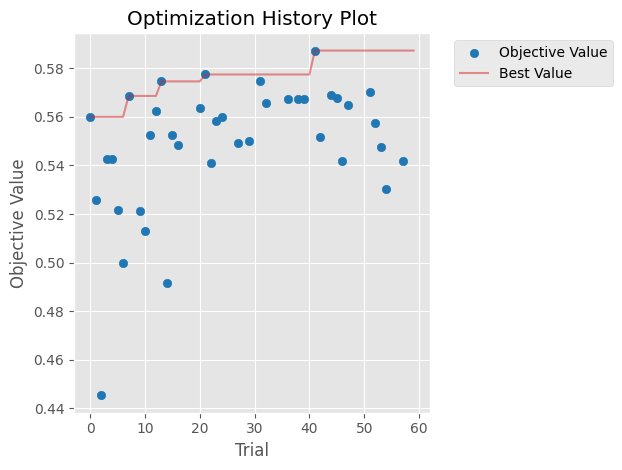

/tmp/ipykernel_653783/1272803483.py:7: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  fig2 = plot_param_importances(study)


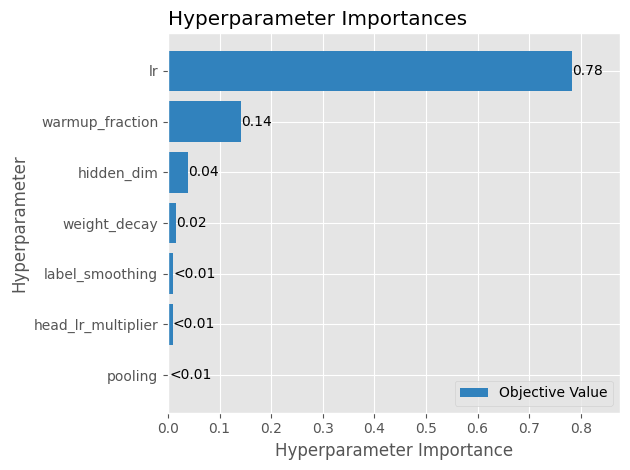

/tmp/ipykernel_653783/1272803483.py:13: ExperimentalWarning: optuna.visualization.matplotlib._parallel_coordinate.plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  fig3 = plot_parallel_coordinate(study)


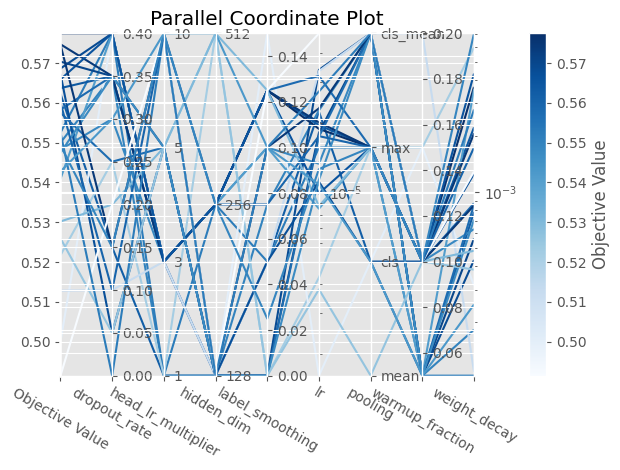

Best hyperparameters for Experiment 1:
  lr: 2.9593617105719396e-05
  hidden_dim: 0
  weight_decay: 0.002686349764251489
  warmup_fraction: 0.05
  pooling: cls_mean
  head_lr_multiplier: 1
  label_smoothing: 0.07500000000000001


In [16]:
fig1 = plot_optimization_history(study)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/optuna_history.png", dpi=300)
plt.savefig(f"{OUT_DIR}/optuna_history.svg", format="svg")
plt.show()

fig2 = plot_param_importances(study)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/optuna_importances.png", dpi=300)
plt.savefig(f"{OUT_DIR}/optuna_importances.svg", format="svg")
plt.show()

fig3 = plot_parallel_coordinate(study)
plt.tight_layout()
plt.savefig(f"{OUT_DIR}/optuna_parallel.png", dpi=300)
plt.savefig(f"{OUT_DIR}/optuna_parallel.svg", format="svg")
plt.show()

best_params = study.best_trial.params
print("Best hyperparameters for Experiment 1:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

In [ ]:
# Load best model from search (no retraining — avoids dev leakage)
best = study.best_trial.params
batch_size = 32
dropout_rate = best.get("dropout_rate", 0.0)

final_model = PCLDeBERTa(
    hidden_dim=best["hidden_dim"],
    dropout_rate=dropout_rate,
    n_extra_features=0,
    pooling=PoolingStrategy(best["pooling"])
).to(DEVICE)

state_dict = torch.load(os.path.join(OUT_DIR, "exp1_best_model.pt"), map_location=DEVICE)
final_model.load_state_dict(state_dict)
LOG.info("Loaded best model weights from search")

# Use threshold already tuned on val_sub during search
best_threshold = study.best_trial.user_attrs["best_threshold"]

# Evaluate on held-out dev set
_, _, dev_loader = make_dataloaders(
    train_sub_df, val_sub_df, dev_df, batch_size, MAX_LENGTH, tokeniser
)
dev_metrics = evaluate(final_model, DEVICE, dev_loader, threshold=best_threshold)

print(f"\nDev Set Results (threshold={best_threshold:.3f}):")
print(classification_report(
    dev_metrics["labels"],
    dev_metrics["preds"],
    target_names=["Non-PCL", "PCL"]
))

# Save params and threshold for experiments 2-4
best_config = {**best, "batch_size": batch_size, "num_epochs": NUM_EPOCHS,
               "patience": PATIENCE, "best_threshold": best_threshold}
with open(os.path.join(OUT_DIR, "exp1_best_params.json"), "w") as f:
    json.dump(best_config, f, indent=2)
LOG.info(f"Model at {OUT_DIR}/exp1_best_model.pt, params at {OUT_DIR}/exp1_best_params.json")

2026-02-17 22:45:49,301 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/config.json "HTTP/1.1 307 Temporary Redirect"
2026-02-17 22:45:49,312 INFO:	HTTP Request: HEAD https://huggingface.co/api/resolve-cache/models/microsoft/deberta-v3-base/8ccc9b6f36199bec6961081d44eb72fb3f7353f3/config.json "HTTP/1.1 200 OK"
2026-02-17 22:45:49,542 INFO:	HTTP Request: HEAD https://huggingface.co/microsoft/deberta-v3-base/resolve/main/model.safetensors "HTTP/1.1 404 Not Found"
2026-02-17 22:45:49,645 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base "HTTP/1.1 200 OK"
2026-02-17 22:45:49,755 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/commits/main "HTTP/1.1 200 OK"
2026-02-17 22:45:49,896 INFO:	HTTP Request: GET https://huggingface.co/api/models/microsoft/deberta-v3-base/discussions?p=0 "HTTP/1.1 200 OK"
2026-02-17 22:45:50,009 INFO:	HTTP Request: GET https://huggingface.co/api/models/micros

Loading weights:   0%|          | 0/198 [00:00<?, ?it/s]

DebertaV2Model LOAD REPORT from: microsoft/deberta-v3-base
Key                                     | Status     |  | 
----------------------------------------+------------+--+-
lm_predictions.lm_head.LayerNorm.bias   | UNEXPECTED |  | 
lm_predictions.lm_head.bias             | UNEXPECTED |  | 
lm_predictions.lm_head.dense.bias       | UNEXPECTED |  | 
lm_predictions.lm_head.LayerNorm.weight | UNEXPECTED |  | 
mask_predictions.dense.weight           | UNEXPECTED |  | 
mask_predictions.classifier.weight      | UNEXPECTED |  | 
mask_predictions.classifier.bias        | UNEXPECTED |  | 
lm_predictions.lm_head.dense.weight     | UNEXPECTED |  | 
mask_predictions.LayerNorm.weight       | UNEXPECTED |  | 
mask_predictions.dense.bias             | UNEXPECTED |  | 
mask_predictions.LayerNorm.bias         | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
2026-02-17 22:45:55,558 INFO:	Backbone model loaded: 


Dev Set Results (threshold=0.500):
              precision    recall  f1-score   support

     Non-PCL       0.95      0.93      0.94      1894
         PCL       0.45      0.53      0.49       199

    accuracy                           0.89      2093
   macro avg       0.70      0.73      0.71      2093
weighted avg       0.90      0.89      0.90      2093

